In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19

import pymc3 as pm
import arviz as az
import itertools

In [2]:
import sys
sys.path.append('../src')
from consumer import DataLoader

In [3]:
dl = DataLoader()
df_ind = dl.get_data()
df_ind.set_index('date', inplace=True)

In [4]:
ind_cases = df_ind['delta.confirmed']
# ind_cases = ind_cases.squeeze()
ind_cases

date
2020-01-30        1.0
2020-02-02        1.0
2020-02-03        1.0
2020-02-14        NaN
2020-03-02        2.0
               ...   
2021-07-23    39501.0
2021-07-24    40286.0
2021-07-25    38179.0
2021-07-26    30820.0
2021-07-27     6656.0
Name: delta.confirmed, Length: 517, dtype: float64

In [5]:
si_distribution = covid19.generate_standard_si_distribution()
delay_distribution = covid19.generate_standard_infection_to_reporting_distribution()

In [6]:
%matplotlib widget
plt.ion()

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].bar(range(len(si_distribution)), si_distribution, width=1)
ax[1].bar(range(len(delay_distribution)), delay_distribution, width=1)
ax[0].set_title('Default serial interval distribution')
ax[1].set_title('Default infection-to-reporting delay distribution')

plt.show()
plt.ioff()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Time Varying $R_t$

In [7]:
ind_cases = ind_cases[4:]

In [8]:
ind_cases.head()

date
2020-03-02     2.0
2020-03-03     1.0
2020-03-04    22.0
2020-03-05     2.0
2020-03-06     1.0
Name: delta.confirmed, dtype: float64

In [9]:
ind_tvr = covid19.r_covid(ind_cases, n_samples=500, smoothing_window=7, r_window_size=7, auto_cutoff=False)
ind_tvr.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-07-23,39501.0,0.593781,2.187337e-06,0.590891,0.593779,0.596677
2021-07-24,40286.0,0.486149,1.923102e-06,0.483434,0.486148,0.488871
2021-07-25,38179.0,0.343946,1.520858e-06,0.341529,0.343945,0.346372
2021-07-26,30820.0,0.174462,8.977378e-07,0.172609,0.174461,0.176326
2021-07-27,6656.0,0.041614,2.631275e-07,0.040614,0.041612,0.042626


In [163]:
%matplotlib widget
plt.ion()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ind_tvr.loc[:,'Q0.5'].plot(ax=ax, color='green')

ax.fill_between(ind_tvr.index, 
                  ind_tvr['Q0.025'], 
                  ind_tvr['Q0.975'],
                  color='green',
                  alpha=0.1)

ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('$R_0(t)$ for India')
plt.show()
plt.ioff()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
df_ka = dl.get_data(state_codes='KA')
df_ka.set_index('date', inplace=True)

src/consumer/api_consumer.py:167: UserWarning: Data is up-to-date. Using local files.
  warnings.warn("Data is up-to-date. Using local files.")


In [12]:
ka_cases = df_ka['delta.confirmed']
ka_cases

date
2020-03-09       1.0
2020-03-10       3.0
2020-03-11       NaN
2020-03-12       1.0
2020-03-13       1.0
               ...  
2021-07-20    1464.0
2021-07-21    1639.0
2021-07-22    1653.0
2021-07-23    1705.0
2021-07-24    1857.0
Name: delta.confirmed, Length: 503, dtype: float64

In [13]:
ka_cases = ka_cases['2020-03-21':]

In [14]:
ka_tvr = covid19.r_covid(ka_cases, n_samples=500, smoothing_window=7, r_window_size=7, auto_cutoff=False)

In [15]:
ka_tvr.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-07-20,1464.0,0.907061,0.000092,0.888280,0.907026,0.926134
2021-07-21,1639.0,1.082878,0.000111,1.062380,1.082844,1.103652
2021-07-22,1653.0,1.353828,0.000142,1.330644,1.353793,1.377167
2021-07-23,1705.0,1.566717,0.000164,1.541660,1.566682,1.591973
2021-07-24,1857.0,1.642504,0.000161,1.617895,1.642472,1.667416


In [162]:
%matplotlib widget
plt.ion()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ka_tvr.loc[:, 'Q0.5'].plot(ax=ax, color='brown')

ax.fill_between(ka_tvr.index, 
                  ka_tvr['Q0.025'], 
                  ka_tvr['Q0.975'],
                  color='brown',
                  alpha=0.1)

ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('$R_0(t)$ for KA')
plt.show()
plt.ioff()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
ka_tvr.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-07-20,1464.0,0.907061,0.000092,0.888280,0.907026,0.926134
2021-07-21,1639.0,1.082878,0.000111,1.062380,1.082844,1.103652
2021-07-22,1653.0,1.353828,0.000142,1.330644,1.353793,1.377167
2021-07-23,1705.0,1.566717,0.000164,1.541660,1.566682,1.591973
2021-07-24,1857.0,1.642504,0.000161,1.617895,1.642472,1.667416


## TPR and CFR Computation

In [18]:
ka_CT = df_ka[['delta.confirmed', 'delta.tested', 'delta.deceased']]
print(ka_CT.head())

            delta.confirmed  delta.tested  delta.deceased
date                                                     
2020-03-09              1.0           NaN             NaN
2020-03-10              3.0           NaN             NaN
2020-03-11              NaN           NaN             NaN
2020-03-12              1.0           NaN             NaN
2020-03-13              1.0           NaN             1.0


In [19]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(ka_CT.index, ka_CT['delta.confirmed'], 'go-', label='Confirmed')
ax.set_ylabel("Tested / Confirmed", color='green', fontsize=14)
ax.legend = True

ax2 = ax.twinx()
ax2.plot(ka_CT.index, ka_CT['delta.deceased'], 'ro--', label='Deceased')
ax2.set_ylabel("Deceased", color="red", fontsize=14)

ax2.legend = True

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
ka_CT['TPR'] = ka_CT['delta.confirmed'] / ka_CT['delta.tested']
ka_CT['CFR'] = ka_CT['delta.deceased'] / ka_CT['delta.confirmed']

/home/anupam/.condaroot/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [21]:
ka_CT

,delta.confirmed,delta.tested,delta.deceased,TPR,CFR
date,,,,,
2020-03-09,1.0,NaN,NaN,NaN,NaN
2020-03-10,3.0,NaN,NaN,NaN,NaN
2020-03-11,NaN,NaN,NaN,NaN,NaN
2020-03-12,1.0,NaN,NaN,NaN,NaN
2020-03-13,1.0,NaN,1.0,NaN,1.000000
...,...,...,...,...,...
2021-07-20,1464.0,113456.0,29.0,0.012904,0.019809
2021-07-21,1639.0,152714.0,36.0,0.010732,0.021965
2021-07-22,1653.0,140343.0,31.0,0.011778,0.018754


In [24]:
%matplotlib widget
ka_CT['TPR'].plot(style='r-', label='TPR', legend=True)
ka_CT['CFR'].loc['2020-03-14':].plot(style='g-', label='CFR', legend=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='date'>

In [46]:
from pytorch_lightning.callbacks import EarlyStopping
import torch
import pytorch_lightning as pl

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [132]:
pl.seed_everything(42)

Global seed set to 42


42

In [133]:
tpr = ka_CT.drop(['delta.confirmed', 'delta.tested', 'delta.deceased'], axis=1)

In [134]:
data = tpr.fillna(0)

In [135]:
data['time_idx'] = np.arange(len(data))

In [136]:
data['series'] = 0

In [203]:
# create dataset and dataloaders
max_encoder_length = 42
max_prediction_length = 14

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="TPR",
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["TPR"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

In [204]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.1828)

In [205]:
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [206]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.697     Total estimated model params size (MB)
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /home/anupam/src/pysrc/covid_modeling/lr_find_temp_model.ckpt


suggested learning rate: 0.0446683592150963


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [207]:
%matplotlib inline

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
)


net = NBeats.from_dataset(
    training,
    learning_rate=2.3e-2,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/anupam/.condaroot/envs/ml/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping 'loss' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")
/home/anupam/.condaroot/envs/ml/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping 'logging_metrics' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.697     Total es

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [208]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [209]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0018)

In [210]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

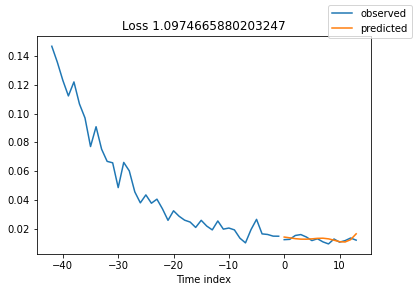

In [243]:
%matplotlib widget
best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

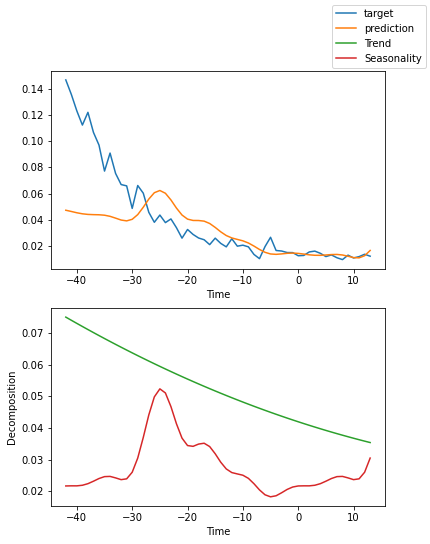

In [212]:
best_model.plot_interpretation(x, raw_predictions, idx=0)

## Predict on new data

In [213]:
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

In [214]:
encoder_data

,TPR,CFR,time_idx,series
date,,,,
2021-06-13,0.060254,0.016005,461,0
2021-06-14,0.045645,0.017557,462,0
2021-06-15,0.038017,0.022813,463,0
2021-06-16,0.043536,0.020150,464,0
2021-06-17,0.037761,0.023065,465,0
2021-06-18,0.040583,0.029051,466,0
2021-06-19,0.033854,0.027687,467,0
2021-06-20,0.025882,0.026566,468,0
2021-06-21,0.032505,0.029176,469,0


In [215]:
last_data = data[lambda x: x.time_idx == x.time_idx.max()]

In [216]:
last_data

,TPR,CFR,time_idx,series
date,,,,
2021-07-24,0.012104,0.015617,502,0


In [217]:
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.index + pd.offsets.Day(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

In [218]:
decoder_data

,TPR,CFR,time_idx,series,date
0,0.012104,0.015617,502,0,2021-07-25
1,0.012104,0.015617,502,0,2021-07-26
2,0.012104,0.015617,502,0,2021-07-27
3,0.012104,0.015617,502,0,2021-07-28
4,0.012104,0.015617,502,0,2021-07-29
5,0.012104,0.015617,502,0,2021-07-30
6,0.012104,0.015617,502,0,2021-07-31
7,0.012104,0.015617,502,0,2021-08-01
8,0.012104,0.015617,502,0,2021-08-02
9,0.012104,0.015617,502,0,2021-08-03


In [219]:
# add time index consistent with "data"
decoder_data["time_idx"] = np.arange(encoder_data['time_idx'].max() + 1, encoder_data['time_idx'].max() + len(decoder_data) + 1)

In [220]:
decoder_data

,TPR,CFR,time_idx,series,date
0,0.012104,0.015617,503,0,2021-07-25
1,0.012104,0.015617,504,0,2021-07-26
2,0.012104,0.015617,505,0,2021-07-27
3,0.012104,0.015617,506,0,2021-07-28
4,0.012104,0.015617,507,0,2021-07-29
5,0.012104,0.015617,508,0,2021-07-30
6,0.012104,0.015617,509,0,2021-07-31
7,0.012104,0.015617,510,0,2021-08-01
8,0.012104,0.015617,511,0,2021-08-02
9,0.012104,0.015617,512,0,2021-08-03


In [221]:
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [222]:
new_prediction_data

,TPR,CFR,time_idx,series,date
0,0.060254,0.016005,461,0,NaT
1,0.045645,0.017557,462,0,NaT
2,0.038017,0.022813,463,0,NaT
3,0.043536,0.020150,464,0,NaT
4,0.037761,0.023065,465,0,NaT
5,0.040583,0.029051,466,0,NaT
6,0.033854,0.027687,467,0,NaT
7,0.025882,0.026566,468,0,NaT
8,0.032505,0.029176,469,0,NaT
9,0.028730,0.037476,470,0,NaT


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

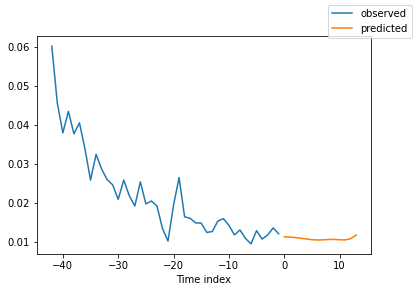

In [223]:
new_raw_predictions, new_x = best_model.predict(new_prediction_data, mode="raw", return_x=True)
best_model.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False)

In [224]:
new_raw_predictions['prediction'] += 0.002

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

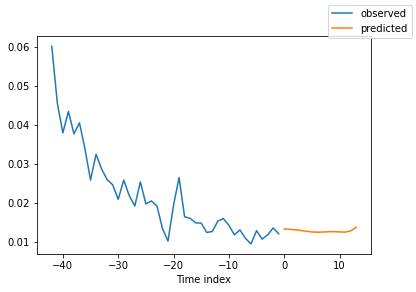

In [225]:
%matplotlib widget
best_model.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False)

In [226]:
new_raw_predictions['prediction']

tensor([[0.0133, 0.0132, 0.0131, 0.0130, 0.0128, 0.0126, 0.0125, 0.0125, 0.0126,
         0.0127, 0.0126, 0.0125, 0.0128, 0.0138]])

In [229]:
decoder_data['prediction'] = new_raw_predictions['prediction'].squeeze().numpy()

In [235]:
out = decoder_data[['date', 'prediction']].set_index('date')
out['predicted TPR %'] = 100 * out['prediction']

In [238]:
out.drop('prediction', axis=1, inplace=True)

In [242]:
%matplotlib widget
out.plot(legend=True, style="ro-")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='date'>

In [245]:
print(out)

            predicted TPR %
date                       
2021-07-25         1.334185
2021-07-26         1.324228
2021-07-27         1.311928
2021-07-28         1.295483
2021-07-29         1.275616
2021-07-30         1.258081
2021-07-31         1.250323
2021-08-01         1.254435
2021-08-02         1.263263
2021-08-03         1.265305
2021-08-04         1.256874
2021-08-05         1.252432
2021-08-06         1.282641
2021-08-07         1.377177
